In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

import soundscapy as ssp

from argparse import Namespace

In [3]:
from utils import *
from pca import CustomPCA
from fa import CustomFactorAnalysis as CustomFA

In [4]:
HOME = os.getcwd()
DATA = os.path.join(HOME, '..', 'data')
calib_mode = 'hats'

df = load_data(DATA, calib_mode)

In [5]:
len(df.pid.unique())

25

In [6]:
sns.set_theme('paper', 'whitegrid')

In [7]:
p1df = pd.read_csv('../data/p1tha.csv').set_index('PAQ')

## Reliability Check

In [8]:
import pingouin as pg

In [9]:
def define_latex_command(name, value, value_format=None):
    
    if value_format is not None:
        if type(value_format) is str:
            value = value_format.format(value)
        else:
            value = value_format(value)
    
    nc = "\\newcommand{\\" + name + "}{" + value + "}"
    
    return nc

In [10]:
tab = []

iccs = {}

for p in PAQ_CCW:
    
    cols = []
    alph, ci = pg.cronbach_alpha(df, subject='pid', items='stimulus_id', scores=p)
    ic = pg.intraclass_corr(df, raters='pid', ratings=p, targets='stimulus_id').set_index('Type')
    
    
    cols += [
        f"tha{p.capitalize()}",
        # f"{alph:.3f}",
        # f"[{ci[0]:.3f}, {ci[1]:.3f}]",
        f"{ic.loc['ICC2']['ICC']:.3f}",
        f"[{ic.loc['ICC2']['CI95%'][0]:.3f}, {ic.loc['ICC2']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2']['F']:.3f}",
        f"$<$0.001",
        f"{ic.loc['ICC2k']['ICC']:.3f}",
        f"[{ic.loc['ICC2k']['CI95%'][0]:.3f}, {ic.loc['ICC2']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2k']['F']:.3f}",
        f"$<$0.001",
    ]
    tab.append(" & ".join(cols))
    # print(define_latex_command(f"cronbach{p.capitalize()}", alph, "{:.3g}"))

    # print(define_latex_command(f"cronbach{p.capitalize()}cilo", ci[0], "{:.3g}"))
    # print(define_latex_command(f"cronbach{p.capitalize()}cihi", ci[1], "{:.3g}"))
    
    iccs[p] = [ic.loc['ICC2']['ICC'], ic.loc['ICC2k']['ICC']]
    
print("\\\\ \n".join(tab) + "\\\\")

thaPl & 0.571 & [0.440, 0.720] & 42.341 & $<$0.001 & 0.971 & [0.950, 0.720] & 42.341 & $<$0.001\\ 
thaVi & 0.590 & [0.460, 0.730] & 41.750 & $<$0.001 & 0.973 & [0.960, 0.730] & 41.750 & $<$0.001\\ 
thaEv & 0.252 & [0.160, 0.400] & 11.425 & $<$0.001 & 0.894 & [0.830, 0.400] & 11.425 & $<$0.001\\ 
thaCh & 0.571 & [0.440, 0.720] & 44.172 & $<$0.001 & 0.971 & [0.950, 0.720] & 44.172 & $<$0.001\\ 
thaAn & 0.547 & [0.420, 0.700] & 39.817 & $<$0.001 & 0.968 & [0.950, 0.700] & 39.817 & $<$0.001\\ 
thaMo & 0.412 & [0.290, 0.580] & 20.235 & $<$0.001 & 0.946 & [0.910, 0.580] & 20.235 & $<$0.001\\ 
thaUn & 0.256 & [0.160, 0.410] & 11.186 & $<$0.001 & 0.896 & [0.830, 0.410] & 11.186 & $<$0.001\\ 
thaCa & 0.593 & [0.460, 0.740] & 47.907 & $<$0.001 & 0.973 & [0.960, 0.740] & 47.907 & $<$0.001\\


In [11]:
for p, (icc2, icc2k) in iccs.items():
    p1df.loc[p, 'ICC2'] = icc2
    p1df.loc[p, 'ICC2k'] = icc2k
    

In [12]:
p1df['isMain'] = p1df.index.isin(['pl', 'an', 'ev', 'un'])

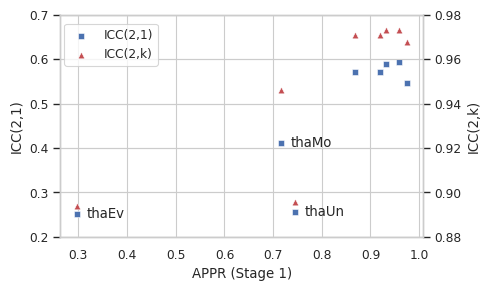

In [13]:
f, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax2 = ax.twinx()

sns.scatterplot(p1df, x='APPR',y='ICC2', marker='s', c='b', ax=ax, label='ICC(2,1)', legend=None)
ax.set(ylim=[0.2, 0.7])
sns.scatterplot(p1df, x='APPR',y='ICC2k', marker='^', c='r', ax=ax2, label='ICC(2,k)', legend=None)
ax2.set(ylim=[0.88, 0.98])

ax.figure.legend(loc='upper left', bbox_to_anchor=(0.125, 0.925))

for p in ['ev', 'mo', 'un']:
    ax.text(x=p1df.loc[p, 'APPR'] + 0.02, y=p1df.loc[p, 'ICC2'], s=f"tha{p.capitalize()}", ha='left', va='center')
    
ax.set(xlabel='APPR (Stage 1)')
ax.set(ylabel='ICC(2,1)')
ax2.set(ylabel='ICC(2,k)')

plt.savefig('figs/appr_vs_icc.png', dpi=300)
plt.show()

# EDA

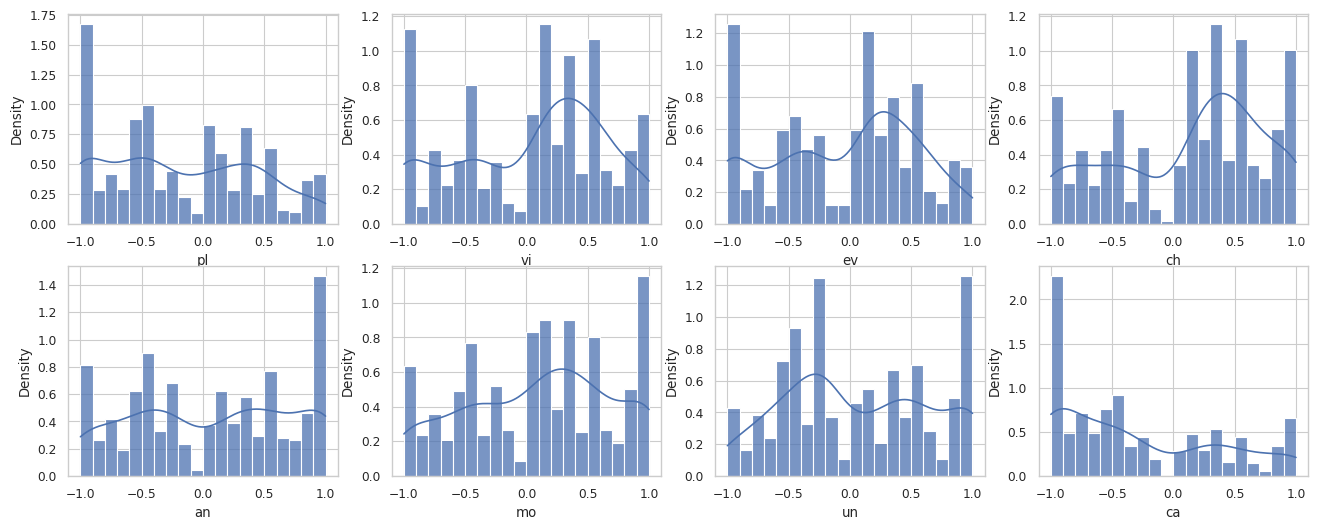

In [14]:
f, axs = plt.subplots(2, 4, figsize=(16, 6), sharex=False)

for i in range(8):
    cax = axs[i//4, i%4]
    sns.histplot(df, x=PAQ_CCW[i], bins=20, stat='density', ax=cax)
    sns.kdeplot(df, x=PAQ_CCW[i], ax=cax, clip=[-1,1])

# sns.pairplot(dfx[PAQ_CCW])

# PCA

In [15]:
from copy import deepcopy

In [16]:
def unitary_transform(pca, targets_proj):
    rpca = deepcopy(pca)

    A = rpca.components_[:2, :] @ targets_proj
    B = np.eye(2, 2)  
    M = B @ A.T
    U, S, Vt = np.linalg.svd(M)

    R = U@Vt

    rpca.components_[:2, :] = R @ rpca.components_[:2, :]
    
    return rpca, R

In [17]:
dfx = df.groupby('stimulus_id').mean()    
pca_raw = CustomPCA(n_components=8, whiten=False, center=False)
pca_mean = CustomPCA(n_components=8, whiten=False, center=False)

pca_raw = pca_raw.fit(df[PAQ_CCW])
pca_mean = pca_mean.fit(dfx[PAQ_CCW])

rpca_raw, Rr = unitary_transform(pca_raw, iso_proj)
rpca_mean, Rm = unitary_transform(pca_mean, iso_proj)

for n, pca in [('ur', pca_raw), ('um', pca_mean), ('rr', rpca_raw), ('rm', rpca_mean)]:
    pcm = pca.transform(dfx[PAQ_CCW])
    pcr = pca.transform(df[PAQ_CCW])
    for i in range(pca.n_components):
        dfx[f'{n}{i+1}proj'] = pcm[:, i]
        df[f'{n}{i+1}proj'] = pcr[:, i]

In [18]:
np.sum(pca_raw.explained_variance_ratio_[:2])

0.8086376732321678

In [19]:
np.sum(pca_mean.explained_variance_ratio_[:2])

0.9441958097009986

In [20]:
np.rad2deg(np.arccos(Rm[0, 0]))

179.84738491781093

In [21]:
def cosine_sim(A, B, feature_axis=-1):
    A = A/np.linalg.norm(A, axis=feature_axis, keepdims=True)
    B = B/np.linalg.norm(B, axis=feature_axis, keepdims=True)
    
    C = np.sum(A*B, axis=feature_axis)
    
    return C

cosine_sim(rpca_raw.components_, rpca_mean.components_)

array([ 0.99805677,  0.96165094,  0.78755704, -0.76499166,  0.66373858,
        0.7740638 ,  0.86821296,  0.98514682])

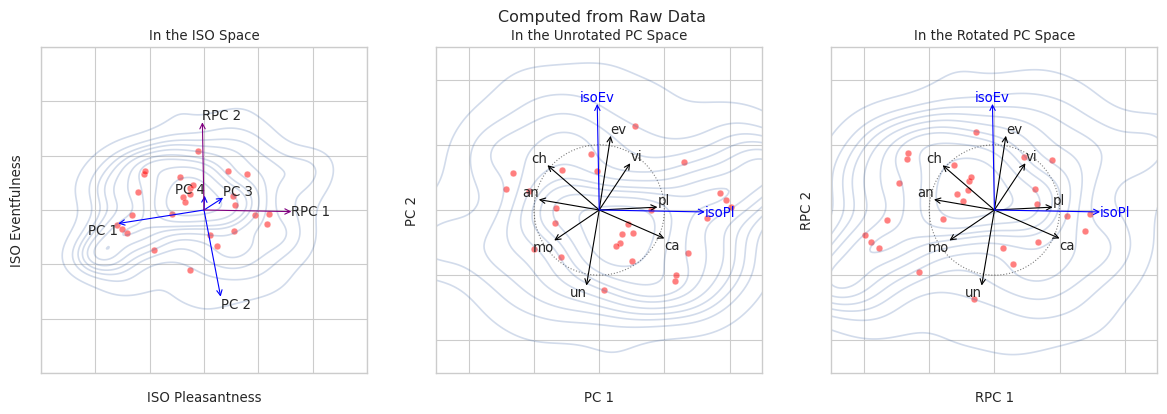

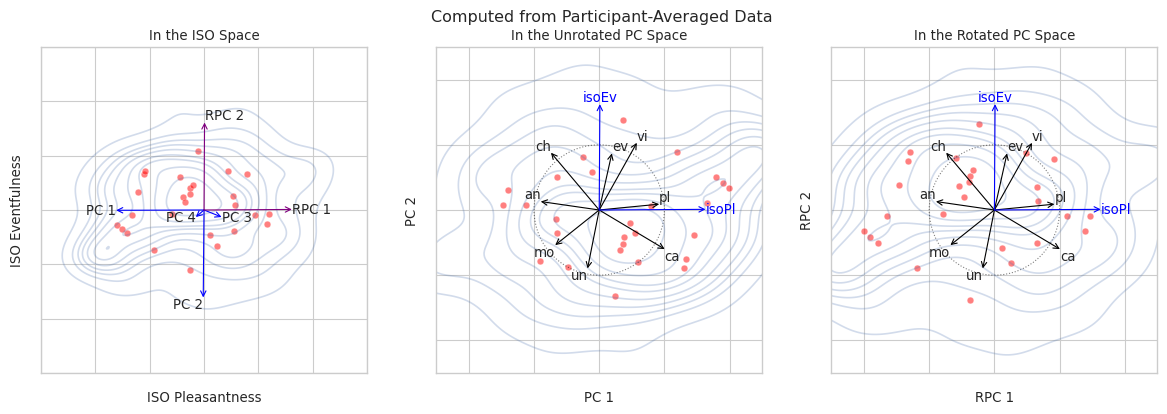

In [273]:


def make_pca_plot(pca, rpca, name):
    
    def plot_in_pc(ax, x, y):
        sns.kdeplot(df, x=x, y=y, levels=10, alpha=0.25, ax=ax)
        sns.scatterplot(dfx, x=x, y=y, marker="o", c="red", alpha=0.5,  ax=ax)

        rdirections = {}
        for i, p in enumerate(PAQ_CCW):
            dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
            rdirections[p] = rpca.transform(dfi)[0, :2]

        r = np.mean([np.linalg.norm(d) for d in rdirections.values()])

        rdirections = {k: v/r for k, v in rdirections.items()}

        isopl_in_rpc = norm_norm(iso_pl(Namespace(**rdirections))) 
        isoev_in_rpc = norm_norm(iso_ev(Namespace(**rdirections))) 
        riso_plev = [isopl_in_rpc, isoev_in_rpc]



        k = 1.0

        for paq, d in rdirections.items():
            # d *= 2
            ax.annotate("", xy=k*d, xytext=(0, 0),
                    arrowprops=dict(arrowstyle="->", ec="black", shrinkA=0, shrinkB=0))
            ax.annotate(paq, xy=k*d, **hava(d, hd="center"))

        for i, p in enumerate(["isoPl", "isoEv"]):
            ax.annotate("", xy=2*k*riso_plev[i], xytext=(0, 0),
                    arrowprops=dict(arrowstyle="->", color="blue", shrinkA=0, shrinkB=0))
            ax.annotate(p, xy=2*k*riso_plev[i], **hava(riso_plev[i], vd="center", hd="center"), color="blue")


        c = plt.Circle((0, 0), 1.0, fc="none", ec="black", ls=":", alpha=0.5)

        ax.add_artist(c)

        lim = 2.5
        ax.axis('scaled')
        ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

    
    mode = name[0]
    
    if mode == 'r':
        suffix = "Computed from Raw Data"
    else:
        suffix = "Computed from Participant-Averaged Data"
        
    
    
    colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
    cmap = mpl.colors.ListedColormap(colors)

    f, axs = plt.subplots(1, 3, figsize=(12,4))
    

    ax = axs[0]

    lim = 1.5

    sns.kdeplot(df, x='isopl', y='isoev', levels=10, alpha=0.25, ax=ax)
    sns.scatterplot(dfx, x='isopl', y='isoev', marker="o", c="red", alpha=0.5, ax=ax)

    pc_in_std = pca.inverse_transform(np.stack([pc_vec(i) for i in range(pca.n_components)], axis=1))[:4]
    pc_in_iso = [norm_norm(iso_np(p)) for p in pc_in_std]

    rpc_in_std = rpca.inverse_transform(np.stack([pc_vec(i) for i in range(pca.n_components)], axis=1))[:2]
    rpc_in_iso = [norm_norm(iso_np(p)) for p in rpc_in_std]

    k = 2.0

    for i, v in enumerate(pc_in_iso):
        ax.annotate("", xy=k*v, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", 
                                ec="blue",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

        # if i < 2:
        ax.annotate(f"PC {i+1}", xy=k*v, **hava(v, thresh=0.05, hd="right", vd="center"))

    for i, v in enumerate(rpc_in_iso[:2]):
        ax.annotate("", xy=k*v, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", 
                                ec="purple",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

        ax.annotate(f"RPC {i+1}", xy=k*v, **hava(v, hd="left", vd="center"))

    ax.set(
        title=f'In the ISO Space', 
        xlabel="ISO Pleasantness",
        ylabel="ISO Eventfulness",
    )

    ax.axis('scaled')
    ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

    ############################################

    ax = axs[1]

    x = f"u{mode}1proj"
    y = f"u{mode}2proj"
    
    plot_in_pc(ax, x, y)

    ax.set(
        title=f"In the Unrotated PC Space",
        xlabel="PC 1",
        ylabel="PC 2"
    )

    ############################################

    ax = axs[2]

    x = f"r{mode}1proj"
    y = f"r{mode}2proj"
    
    plot_in_pc(ax, x, y)

    
    ax.set(
        title=f"In the Rotated PC Space",
        xlabel="RPC 1",
        ylabel="RPC 2"
    )

   
    plt.suptitle(suffix, x=0.515, ha='center')

    plt.tight_layout()
    plt.savefig(f"figs/pca-{name}.png", dpi=300)

    plt.show()
    
make_pca_plot(pca_raw, rpca_raw, 'raw')
make_pca_plot(pca_mean, rpca_mean, 'mean')

## Compute Scores

In [23]:
# only use rpca_mean from now

pca = rpca_mean

In [24]:
fulldir = {}
for i, p in enumerate(PAQ_CCW):
    dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
    fulldir[p] = pca.transform(dfi)[0, :]

isopl_in_pc = norm_norm(iso_pl(Namespace(**fulldir)))
isoev_in_pc = norm_norm(iso_ev(Namespace(**fulldir)))

fulldir['isopl'] = isopl_in_pc
fulldir['isoev'] = isoev_in_pc

# fulldir

In [25]:
pca.transform(dfi)

array([[ 0.49814255, -0.29765865, -0.48844687,  0.39298564, -0.33567903,
        -0.19226423, -0.34723601, -0.00405918]])

In [232]:
def adj(p):
    i = PAQ_CCW.index(p)
    return PAQ_CCW[(i-1) % 8], PAQ_CCW[(i+1) % 8]

def orth(p):
    i = PAQ_CCW.index(p)
    return PAQ_CCW[(i-2) % 8], PAQ_CCW[(i+2) % 8]

def anti(p):
    i = PAQ_CCW.index(p)
    return PAQ_CCW[(i-4) % 8], PAQ_CCW[(i+4) % 8]

def angular_diff(a, b):
    d = a - b
    d = (d + 180) % 360 - 180
    return d

def abs_angular_diff(a, b):
    return np.abs(angular_diff(a, b))

def twosided_diff(df, func):
    
    
    err1 = abs_angular_diff(
        df.loc[PAQ_CCW, "angle"].values, 
        df.loc[[func(i)[0] for i in PAQ_CCW]]["angle"].values
    )
    
    err2 = abs_angular_diff(
        df.loc[PAQ_CCW, "angle"].values, 
        df.loc[[func(i)[1] for i in PAQ_CCW]]["angle"].values
    )
    
    return np.abs(
        err1 - err2
    )


def balance_err(df, func):
    err1 = df.loc[[func(i)[0] for i in PAQ_CCW], "pcproj"].values[:2] - df.loc[PAQ_CCW, "pcproj"].values[:2]
    err2 = df.loc[[func(i)[1] for i in PAQ_CCW], "pcproj"].values[:2] - df.loc[PAQ_CCW, "pcproj"].values[:2]
    
    n1 = np.linalg.norm(err1)
    n2 = np.linalg.norm(err2)
    
    return np.abs(n1 - n2)/((n1+n2)/2)

In [268]:
data = {
    p: {
        'pcproj': fulldir[p],
        'ideal': np.array(
            [np.cos(i * np.pi/4), np.sin(i * np.pi/4)] + [0 for _ in range(6)]
        )
    } for i, p in enumerate(PAQ_CCW)
}


for p in ['pl', 'ev']:
    data['iso'+p] = {
        'pcproj': fulldir['iso'+p],
        'ideal': data[p]['ideal']
    }

dfy = pd.DataFrame(data).T

def dir2ang(x, y):
    return (180.0 / np.pi) * np.arctan2(y, x)

dfy["angle"] = dfy['pcproj'].apply(
    lambda v: dir2ang(v[0], v[1])
)

dfy["ang_ideal"] = dfy['ideal'].apply(
    lambda v: dir2ang(v[0], v[1])
)

dfy['isMain'] = dfy.index.isin(['pl', 'an', 'ev', 'un']) + 2 * dfy.index.isin(['isopl', 'isoev'])

r = np.linalg.norm(np.stack(dfy.loc[PAQ_CCW].pcproj.values, axis=0)[:, :2], axis=-1)
rhat = np.mean(r)

dfy["pcproj"] = dfy["pcproj"]/rhat

In [271]:


dfy["aLoc"] = np.abs(dfy["angle"]  - dfy["ang_ideal"]) 
dfy.loc[PAQ_CCW, "rLoc"] = np.linalg.norm(np.stack(dfy.loc[PAQ_CCW].pcproj.values, axis=0)[:, :2], axis=-1) - 1

dfy.loc[PAQ_CCW, "aAnti"] = np.abs(
    abs_angular_diff(
        dfy.loc[PAQ_CCW, "angle"].values, 
        dfy.loc[[anti(i)[1] for i in PAQ_CCW]]["angle"].values
    ) - 180)


dfy.loc[PAQ_CCW, "rAnti"] = balance_err(dfy, anti)

dfy.loc[PAQ_CCW, "aOrth"] = twosided_diff(dfy, orth)
dfy.loc[PAQ_CCW, "rOrth"] = balance_err(dfy, orth)

dfy.loc[PAQ_CCW, "aAdj"] = twosided_diff(dfy, adj)
dfy.loc[PAQ_CCW, "rAdj"] = balance_err(dfy, adj)





In [270]:

dfy.loc[dfy['isMain'] == 0, [c for c in dfy.columns if "Orth" in c or "Anti" in c]] = np.nan

dfy.loc[["isopl", "isoev"], "OrthErr"] = np.abs(abs_angular_diff(dfy.loc["isopl", "angle"], dfy.loc["isoev", "angle"]) - 90)

dfy = dfy.sort_values("isMain", ascending=False)

print(dfy[[k for k in dfy.columns if k[0] in ["a", "m", "r"]]].to_latex(formatters={
    **{k: (lambda x: f"{x:-2.1f}") for k in dfy.columns if k[0] == "a"},
    **{k: (lambda x: f"{x:-0.3f}") for k in dfy.columns if k[0] in ["m", "r"]} 
}))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  angle & ang\_ideal & aLoc &   rLoc & aAnti & aOrth & rOrth & aAdj &  rAdj \\
\midrule
isopl &    0.4 &       0.0 &  0.4 &    NaN &   NaN &   NaN &   NaN &  NaN &   NaN \\
isoev &   89.6 &      90.0 &  0.4 &    NaN &   NaN &   NaN &   NaN &  NaN &   NaN \\
pl    &    5.6 &       0.0 &  5.6 & -0.075 &  13.8 &  34.9 & 0.242 & 18.8 & 0.371 \\
ev    &   77.4 &      90.0 & 12.6 & -0.110 &   1.3 &  22.5 & 0.490 & 36.0 & 0.358 \\
an    &  171.8 &     180.0 &  8.2 & -0.094 &  13.8 &   7.4 & 0.831 &  5.1 & 0.585 \\
un    & -101.3 &     -90.0 & 11.3 & -0.086 &   1.3 &  19.9 & 0.165 & 30.3 & 0.795 \\
vi    &   60.8 &      45.0 & 15.8 &  0.181 &   NaN &   NaN &   NaN & 38.5 & 0.200 \\
ch    &  130.1 &     135.0 &  4.9 &  0.149 &   NaN &   NaN &   NaN & 11.0 & 0.316 \\
mo    & -141.4 &    -135.0 &  6.4 & -0.136 &   NaN &   NaN &   NaN &  6.7 & 0.106 \\
ca    &  -30.9 &     -45.0 & 14.1 &  0.170 &   NaN &   NaN &   NaN & 34.0 & 1.040 \\
\bottomrule
\end{tabu

In [318]:
l0 = np.stack(dfy.loc[PAQ_CCW, 'ideal'].values, axis=0)[:, :2]
l = np.stack(dfy.loc[PAQ_CCW, 'pcproj'].values, axis=0)[:, :2]
newiso = np.linalg.lstsq(l.T, l0.T)

# np.rad2deg(np.arccos(newiso))[:, :2]
newiso[0].shape

(8, 8)

## Comparison to Eng

In [285]:
dfeng = pd.read_excel("../data/engUCL-paq.xlsx")[["Participant", "Recording"] + PAQ_CCW]

for col in PAQ_CCW:
    dfeng[col] = dfeng[col].apply(normalize_response) #.apply(double_square)
        
dfeng['isopl'] = dfeng.apply(iso_pl, axis=1).apply(norm_norm)
dfeng['isoev'] = dfeng.apply(iso_ev, axis=1).apply(norm_norm)

dfengx = dfeng.groupby("Recording").mean().sort_index()

In [37]:
def stim2filename(s):
    fnames = ['CG01',
 'CG04',
 'CT301',
 'E01b',
 'E02',
 'E05',
 'E09',
 'CG07',
 'E11b',
 'E12b',
 'E10',
 'HR01',
 'KT01',
 'LS06',
 'N1',
 'OS01c',
 'OS01d',
 'RPJ01',
 'VP01b',
 'W01',
 'W06',
 'W09',
 'W11a',
 'W15',
 'W16',
 'W22',
 'W23a']
    
    return fnames[int(s)-1]

In [46]:
df['Recording'] = df['stimulus_id'].apply(stim2filename)
dfx['Recording'] = dfx.index.to_series().apply(stim2filename)
dfx2 = dfx.set_index("Recording").sort_index()

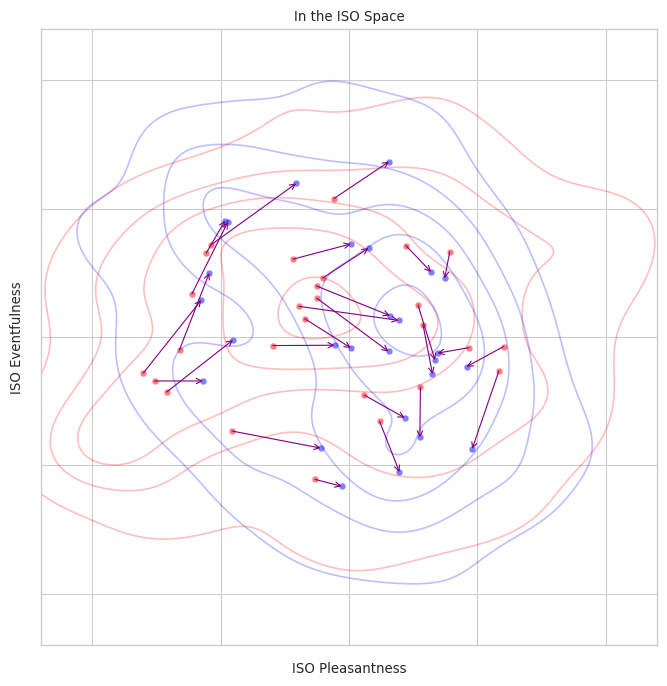

In [57]:
colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
cmap = mpl.colors.ListedColormap(colors)

f, ax = plt.subplots(1, 1, figsize=(8,8))

lim = 1.2

levels = [0.05, 0.25, 0.5, 0.75, 0.95]

sns.kdeplot(df, x='isopl', y='isoev', color="red", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfx, x='isopl', y='isoev', marker="o", c="red", alpha=0.5, ax=ax)

sns.kdeplot(dfeng, x='isopl', y='isoev', color="blue", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfengx, x='isopl', y='isoev', marker="o", c="blue", alpha=0.5, ax=ax)

for r in dfengx.index:
    ax.annotate("", xytext=(dfx2.loc[r, "isopl"], dfx2.loc[r, "isoev"]), 
                xy=(dfengx.loc[r, "isopl"], dfengx.loc[r, "isoev"]),
                arrowprops=dict(arrowstyle="->", 
                                ec="purple",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

ax.set(
    title=f'In the ISO Space', 
    xlabel="ISO Pleasantness",
    ylabel="ISO Eventfulness",
)

ax.axis('scaled')
ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

plt.show()

In [330]:
dfx3 = dfx2.copy()

y0 = dfx2[PAQ_CCW].values

y1 = newiso[0].T @ y0.T

dfx3[PAQ_CCW] = y1.T

dfx3['isopl'] = dfeng.apply(iso_pl, axis=1).apply(norm_norm)
dfx3['isoev'] = dfeng.apply(iso_ev, axis=1).apply(norm_norm)

In [359]:
from scipy.optimize import minimize

def apply(x, dfx2, dfx3):
    x = np.reshape(x, (9, 8))
    y0 = dfx2[PAQ_CCW].values
    y0 = np.concatenate([y0, np.ones_like(y0[:, [0]])], axis=-1)
    
    y1 = y0 @ x
    dfx3[PAQ_CCW] = y1

    dfx3['isopl'] = dfx3.apply(iso_pl, axis=1).apply(norm_norm)
    dfx3['isoev'] = dfx3.apply(iso_ev, axis=1).apply(norm_norm)
    
    return dfx3

def l2err(x):
    
    apply(x, dfx2, dfx3)
    
    return np.linalg.norm(np.stack((dfengx[['isopl', 'isoev']] - dfx3[['isopl', 'isoev']]).values, axis=0), axis=None)
    
out = minimize(l2err, np.random.randn(72))

In [360]:
df3 = apply(out.x, df, df)

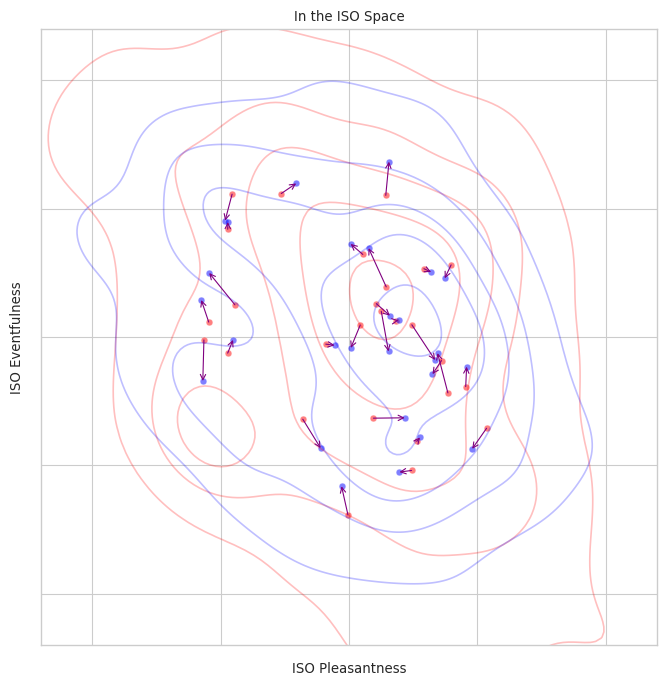

In [361]:
colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
cmap = mpl.colors.ListedColormap(colors)

f, ax = plt.subplots(1, 1, figsize=(8,8))

lim = 1.2

levels = [0.05, 0.25, 0.5, 0.75, 0.95]

sns.kdeplot(df3, x='isopl', y='isoev', color="red", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfx3, x='isopl', y='isoev', marker="o", c="red", alpha=0.5, ax=ax)

sns.kdeplot(dfeng, x='isopl', y='isoev', color="blue", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfengx, x='isopl', y='isoev', marker="o", c="blue", alpha=0.5, ax=ax)

for r in dfengx.index:
    ax.annotate("", xytext=(dfx3.loc[r, "isopl"], dfx3.loc[r, "isoev"]), 
                xy=(dfengx.loc[r, "isopl"], dfengx.loc[r, "isoev"]),
                arrowprops=dict(arrowstyle="->", 
                                ec="purple",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

ax.set(
    title=f'In the ISO Space', 
    xlabel="ISO Pleasantness",
    ylabel="ISO Eventfulness",
)

ax.axis('scaled')
ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

plt.show()

In [40]:
x = """track_1.wav	CG01.wav	CG01.wav
track_2.wav	CG04.wav	CG04.wav
track_3.wav	CG07.wav	CT301.wav
track_4.wav	CT301.wav	E01b.wav
track_5.wav	E01b.wav	E02.wav
track_6.wav	E02.wav	E05.wav
track_7.wav	E05.wav	E09.wav
track_8.wav	E09.wav	CG07.wav
track_9.wav	E10.wav	E11b.wav
track_10.wav	E11b.wav	E12b.wav
track_11.wav	E12b.wav	E10.wav
track_12.wav	HR01.wav	HR01.wav
track_13.wav	KT01.wav	KT01.wav
track_14.wav	LS06.wav	LS06.wav
track_15.wav	N1.wav	N1.wav
track_16.wav	OS01c.wav	OS01c.wav
track_17.wav	OS01d.wav	OS01d.wav
track_18.wav	RPJ01.wav	RPJ01.wav
track_19.wav	VP01b.wav	VP01b.wav
track_20.wav	W01.wav	W01.wav
track_21.wav	W06.wav	W06.wav
track_22.wav	W09.wav	W09.wav
track_23.wav	W11a.wav	W11a.wav
track_24.wav	W15.wav	W15.wav
track_25.wav	W16.wav	W16.wav
track_26.wav	W22.wav	W22.wav
track_27.wav	W23a.wav	W23a.wav"""

In [41]:
[s[2].replace(".wav", "") for s in [xx.split("\t") for xx in x.split("\n")]]

['CG01',
 'CG04',
 'CT301',
 'E01b',
 'E02',
 'E05',
 'E09',
 'CG07',
 'E11b',
 'E12b',
 'E10',
 'HR01',
 'KT01',
 'LS06',
 'N1',
 'OS01c',
 'OS01d',
 'RPJ01',
 'VP01b',
 'W01',
 'W06',
 'W09',
 'W11a',
 'W15',
 'W16',
 'W22',
 'W23a']